In [1]:
__author__ = 'Monika Soraisam'
__email__ = 'monika.soraisam@noirlab.edu'

## Refer here for more details https://dragons.readthedocs.io/projects/recipe-system-prog-manual/en/v3.2.0/intro.html



## TAKEAWAY:
- the `recipe_system.reduction.coreReduce.Reduce` is already robust and will be able to handle customized recipes sent from the GOATS frontend.
- we DO NOT need to figure out the python class of the instrument and its mode to use<br>
e.g., suppose the observation ID to be reduced is that from GMOS instrument in imaging mode. In one of the earlier notebooks I wrote  (*demo_dragons_reduction_gmos_imaging_spectrosocpy.ipynb*), for recipe customization I used to create an instance `p = gmos.primitives_gmos_image.GMOSImage(adin)`, which was then passed on as an argument to the customized recipe function, i.e., `customized_recipe_blah(p)`. I found that this is inadequate; in particular, we will need to always figure out the isntrument beforehand and the default parameters may not be rightly reflected when instantiating this way.

  Turns out it's much simpler. All of these things will be correctly handled by `recipe_system.reduction.coreReduce.Reduce`; it will automatically also figure out the intrument class.  

Go through this notebook to undertsand the primitive and recipe mapping. Lastly, main details for using `recipe_system.reduction.coreReduce.Reduce` with recipe customization are consolidated in ["Everything handled by Reduce class" block at the bottom of notebook](#blah). 


## Update: 2024-07-03 
Apparently, one cannot simply pass the function name (the callable) to `Reduce` as it takes only a string as argument for recipename. On the otherhand, if the new recipe is not in the DRAGONS codebase, it crashes. One way to go about then is to use the `RecipeMapper` and `PrimitiveMapper` classes. But the more elegant way is to still use the `Reduce` class. Dan figured out that the argument needed to pass to the recipename is actually the module name. So, in other words, the customized recipe needs to be first converted into a module. 

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import inspect

# for bokeh apps to load from the jupyter notebook on a different browser tab
import nest_asyncio
nest_asyncio.apply()

In [3]:
# Now import the DRAGONS libraries 
import astrodata
import gemini_instruments

from gempy.scripts import showpars
from gempy.utils.showrecipes import showrecipes
from gempy.utils.showrecipes import showprims

from recipe_system.mappers.primitiveMapper import PrimitiveMapper
from recipe_system.mappers.recipeMapper import RecipeMapper

In [4]:
from recipe_system.reduction.coreReduce import Reduce
from recipe_system import cal_service
from gempy.adlibrary import dataselect
from gempy.utils import logutils

In [5]:
## prep the reduction folder
def prep_reduction_folder(data_root, obsid):
    reduction_path = Path(f"{data_root}/{obsid}/reduction")

    if not reduction_path.exists():
        os.mkdir(reduction_path.as_posix())
        print (f"directory for dragons reduction created")
    
    ## change the cwd to the reduction folder
    os.chdir(reduction_path.as_posix())
    print(f"Current working directory is: {os.getcwd()}")

    ## write the configuration file 
    mydb = "dragons_for_goats.db" 
    mydb_path = reduction_path.as_posix() + '/' + mydb
    print (mydb_path)
    
    dragons_rc = reduction_path.as_posix() + '/dragonsrc'
    print (dragons_rc)
    
    with open(dragons_rc, "w") as f:
        f.write("[calibs]\ndatabases = {0} get store".format(mydb_path))

    return dragons_rc, mydb_path


# GMOS longslit example

In [6]:
#data_path = "/data/goats_dev_data/example_data/data/ZTF18acppavh/GEM" ## linux machine 
data_path = "/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18aabfthf/GEM" ## mac 
obsid = 'GS-2021A-DD-102-9'
dragons_rc, mydb_path = prep_reduction_folder(data_path, obsid)

Current working directory is: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18aabfthf/GEM/GS-2021A-DD-102-9/reduction
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18aabfthf/GEM/GS-2021A-DD-102-9/reduction/dragons_for_goats.db
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18aabfthf/GEM/GS-2021A-DD-102-9/reduction/dragonsrc


In [7]:
# initialize the calibration database and complete the set-up 
caldb = cal_service.LocalDB(mydb_path, force_init=True) # 


In [8]:
logutils.config(file_name='gmos_data_reduction.log') # logger

### Generate filelist for the data reduction

In [9]:
def generate_filelists(location, obsid):
    """
    Parameters
    ----------
    location: str
        Root folder where the Gemini data for a given target is located
    obsid: str
        Gemini observation ID 
    """

    
    all_files = [str(pp) for pp in list(Path(location+"/"+obsid).glob('*.fits'))]
    all_files.sort()
    print (f'The total number of files for observation ID {obsid} is {len(all_files)}')

    cal_file_tags = ['BIAS','DARK','FLAT','ARC','PINHOLE','RONCHI','FRINGE'] #fetched from Obs Type search field on GOA, which is relevant for DRAGONS

    meta_keys = cal_file_tags + ['BPM','standard','object','unknown']
    all_meta = {}

    for K in meta_keys:
        all_meta[K] = {'file':[],
                        'group_id':[],
                        'exp':[],
                        'objname':[],
                        'wave':[],
                        'waveband':[],
                        'date':[],
                        'roi':[],
                        }

    object_files = []
    for i,F in enumerate(all_files):
        ad = astrodata.open(F)

        K = "unknown"
        if "BPM" in ad.tags:
            K = "BPM"
        elif "PREPARED" in ad.tags:
            continue
        elif ("STANDARD" in ad.tags or ad.observation_class()=="partnerCal" or ad.observation_class()=="progCal") and ("UNPREPARED" in ad.tags) and (ad.observation_type()=="OBJECT"):
            K = "standard"            
        elif "CAL" in ad.tags and "UNPREPARED" in ad.tags:
            for tag in cal_file_tags:
                if tag in ad.tags:
                    K = tag
        elif ad.observation_class()=="science" and "UNPREPARED" in ad.tags:
            K = "object"
            
        all_meta[K]['file'].append(F)
        # group_id seems to be not implemented for GNIRS yet
        if "GNIRS" in ad.instrument():
            all_meta[K]['group_id'].append(None)
        else:
            all_meta[K]['group_id'].append(ad.group_id())
        all_meta[K]['exp'].append(ad.exposure_time())
        all_meta[K]['objname'].append(ad.object())
        all_meta[K]['wave'].append(ad.central_wavelength())
        all_meta[K]['waveband'].append(ad.wavelength_band())
        all_meta[K]['date'].append(ad.ut_date())
        all_meta[K]['roi'].append(ad.detector_roi_setting()) 
        #print (F.split('/')[-1], ad.object(), ad.tags)
    
    return all_meta


In [10]:
all_meta = generate_filelists(data_path, obsid)

for K,V in all_meta.items():
    if len(V['file'])==0:
        continue
    print (f"There are {len(V['file'])} files for observation type {K}")


The total number of files for observation ID GS-2021A-DD-102-9 is 58
There are 50 files for observation type BIAS
There are 2 files for observation type FLAT
There are 2 files for observation type ARC
There are 3 files for observation type object
There are 1 files for observation type unknown


In [11]:
DF_bias = pd.DataFrame(all_meta['BIAS'])
DF_flat = pd.DataFrame(all_meta['FLAT'])
#DF_bpm = pd.DataFrame(all_meta['BPM'])
DF_arc = pd.DataFrame(all_meta['ARC'])
DF_object = pd.DataFrame(all_meta['object'])


In [12]:
## add BPM to the calibration database (the BPM is already processed)
for F in caldb.list_files():
    print (F)

# for F in DF_bpm['file'].values:
#     caldb.add_cal(F)

for F in caldb.list_files():
    print (F)

## For each group of files, below one can see how it could be mapped to the appropriate/default recipe and primitives. 

### Bias

In [15]:
## Let's look at the flat group
DF_bias.head()

,file,group_id,exp,objname,wave,waveband,date,roi
0,/data/goats_dev_data/example_data/data/ZTF18ac...,"2_2_Normal_[""'BI5-36-4k-2, 4':[1:512,1:4224]"",...",0.0,Bias,6.750000e-07,None,2021-02-11,Full Frame
1,/data/goats_dev_data/example_data/data/ZTF18ac...,"2_2_Normal_[""'BI5-36-4k-2, 4':[1:512,1:4224]"",...",0.0,Bias,6.750000e-07,None,2021-02-11,Full Frame
2,/data/goats_dev_data/example_data/data/ZTF18ac...,"2_2_Normal_[""'BI5-36-4k-2, 4':[1:512,1:4224]"",...",0.0,Bias,6.750000e-07,None,2021-02-11,Full Frame
3,/data/goats_dev_data/example_data/data/ZTF18ac...,"2_2_Normal_[""'BI5-36-4k-2, 4':[1:512,1:4224]"",...",0.0,Bias,6.750000e-07,None,2021-02-11,Full Frame
4,/data/goats_dev_data/example_data/data/ZTF18ac...,"2_2_Normal_[""'BI5-36-4k-2, 4':[1:512,1:4224]"",...",0.0,Bias,6.750000e-07,None,2021-02-11,Full Frame


In [16]:
ad = astrodata.open(DF_bias['file'].values[0]) ## just take any file from the group; I'm taking the first file. The purpose is to get the corresponding tags of the group
tags = ad.tags
instpkg = ad.instrument(generic=True).lower()

In [17]:
## the tags and instrument package name are used as arguments to the mappers

rmapper = RecipeMapper(tags, instpkg) # recipe mapper 
pmapper = PrimitiveMapper(tags, instpkg) # primitive mapper

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
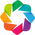

In [18]:
## now get the applicable recipe and primitives corresponding to the tags and instrument package

pclass = pmapper.get_applicable_primitives() 
recipe = rmapper.get_applicable_recipe()

In [19]:
pclass

geminidr.gmos.primitives_gmos.GMOS

In [20]:
recipe

<function geminidr.gmos.recipes.sq.recipes_BIAS.makeProcessedBias(p)>

In [21]:
## Let's examine the sequence of primitives in the recipe 
print(inspect.getsource(recipe.__code__))

def makeProcessedBias(p):
    """
     This recipe performs the standardization and corrections needed to convert
     the raw input bias images into a single stacked bias image. This output
     processed bias is stored on disk using storeProcessedBias and has a name
     equal to the name of the first input bias image with "_bias.fits" appended.

     Parameters
     ----------
     p : PrimitivesBASE object
         A primitive set matching the recipe_tags.
     """

    p.prepare()
    p.addDQ(add_illum_mask=False)
    p.addVAR(read_noise=True)
    p.overscanCorrect()
    p.stackBiases()
    p.makeIRAFCompatible()
    p.storeProcessedBias()
    return



**Note that the default recipe is chosen with the recipeMapper. If one were to see all possible recipes for a given group of files, then one will instead have to use gempy.utils.showrecipes**

**Now instantiate the `pclass` with a list of astrodata objects of the corresponding input files** 

In [22]:
ad_input_list = []

for F in DF_bias['file'].values:
    ad_input_list.append(astrodata.open(F))

len(ad_input_list)

50

In [23]:
pclass?

Init signature:
pclass(
    adinputs,
    mode='sq',
    ucals=None,
    uparms=None,
    upload=None,
    config_file=None,
)
Docstring:     
This is the class containing all of the preprocessing primitives
for the GMOS level of the type hierarchy tree. It inherits all
the primitives from the level above
File:           /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/gmos/primitives_gmos.py
Type:           type
Subclasses:     GMOSSpect, GMOSNodAndShuffle, GMOSImage

In [24]:
## create an instance of the applicable primitive set
p = pclass(ad_input_list, config_file=dragons_rc)

In [ ]:
## let's see all the primitives/methods in this primitive set

for item in dir(p):
   if not item.startswith('_') and inspect.ismethod(getattr(p, item)):
       print(item)

**When one calls a recipe, it's just executing SEQUENTIALLY some number of the above instantiated primitive set methods** 

In [ ]:
recipe(p)

#
### Flat

In [13]:
ad = astrodata.open(DF_flat['file'].values[0]) 
tags = ad.tags
instpkg = ad.instrument(generic=True).lower()
print (instpkg)

gmos


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
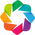

In [14]:
rmapper = RecipeMapper(tags, instpkg) # recipe mapper 
pmapper = PrimitiveMapper(tags, instpkg) # primitive mapper


recipe = rmapper.get_applicable_recipe()
pclass = pmapper.get_applicable_primitives() 

In [15]:
recipe

<function geminidr.gmos.recipes.sq.recipes_FLAT_LS_SPECT.makeProcessedFlatNoStack(p)>

In [16]:
pclass

geminidr.gmos.primitives_gmos_longslit.GMOSLongslit

In [17]:
ad_input_list = []

for F in DF_flat['file'].values:
    ad_input_list.append(astrodata.open(F))

len(ad_input_list)

2

In [18]:
## create an instance of the applicable primitive set
p = pclass(ad_input_list, config_file=dragons_rc)

In [36]:
## let's see all the prmitives/methods in this primitive set

for item in dir(p):
   if not item.startswith('_') and inspect.ismethod(getattr(p, item)):
       print("\n")
       print (item)
       print(getattr(p, item).__doc__)



ADUToElectrons

        This primitive will convert the units of the pixel data extensions
        of the input AstroData object from ADU to electrons by multiplying
        by the gain. The gain keyword in each extension is then set to 1.0
        to represent the new conversion factor.

        Parameters
        ----------
        suffix: str/None
            suffix to be added to output filenames
        


QECorrect

        This primitive applies a wavelength-dependent QE correction to
        a 2D spectral image, based on the wavelength solution in the WCS
        (from `attachWavelengthSolution` or, in non-SQ-modes, the initial
        linear approximation).

        It is only designed to work on FLATs, and therefore unmosaicked data.

        Parameters
        ----------
        suffix: str
            suffix to be added to output files
        


addDQ

        This primitive is used to add a DQ extension to the input AstroData
        object. The value of a pixel in the 

In [46]:
# How to view parameters assigned for a chosen primitive

showpars.showpars(p, 'addDQ', tags, show_docstring=True)

Dataset tagged as {'RAW', 'SPECT', 'SIDEREAL', 'FLAT', 'CAL', 'GEMINI', 'LS', 'GCALFLAT', 'UNPREPARED', 'SOUTH', 'GMOS'}

Settable parameters on 'addDQ':
Name                 Current setting      Description

suffix               '_dqAdded'           Filename suffix
illum_mask           None                 Name of illumination mask
shift                None                 User-defined shift for illumination mask
	Valid Range = [-100,100]
max_shift            50                   Maximum (unbinned) pixel shift for illumination mask
	Valid Range = [0,100]
static_bpm           'default'            Static bad pixel mask
user_bpm             None                 User bad pixel mask
add_illum_mask       True                 Apply illumination mask?

Docstring for 'addDQ':

This primitive is used to add a DQ extension to the input AstroData
object. The value of a pixel in the DQ extension will be the sum of the
following: (0=good, 1=bad pixel (found in bad pixel mask), 2=pixel is
in the non

In [28]:
## Let's examine the sequence of primitives in the chosen recipe 
print(inspect.getsource(recipe.__code__))

def makeProcessedFlatNoStack(p):
    p.prepare()
    p.addDQ()
    p.addVAR(read_noise=True)
    p.overscanCorrect()
    p.biasCorrect()
    p.ADUToElectrons()
    p.addVAR(poisson_noise=True)
    p.normalizeFlat()
    p.thresholdFlatfield()
    p.makeIRAFCompatible()
    p.storeProcessedFlat()



In [ ]:
recipe(p)

In [74]:
for F in caldb.list_files():
    print (F)

FileData(name='S20210211S0068_bias.fits', path='/data/goats_dev_data/example_data/data/ZTF18acppavh/GEM/GS-2021A-DD-102-9/reduction/calibrations/processed_bias')
FileData(name='S20210219S0077_flat.fits', path='/data/goats_dev_data/example_data/data/ZTF18acppavh/GEM/GS-2021A-DD-102-9/reduction/calibrations/processed_flat')
FileData(name='S20210219S0078_flat.fits', path='/data/goats_dev_data/example_data/data/ZTF18acppavh/GEM/GS-2021A-DD-102-9/reduction/calibrations/processed_flat')
FileData(name='bpm_20140601_gmos-s_Ham_22_full_12amp.fits', path='/data/goats_dev_data/example_data/data/ZTF18acppavh/GEM/GS-2021A-DD-102-9')


**Let's say the user has customized the flat recipe on GOATS as follows -- adding the interactive=True for nomalizeFlat primitive**

In [29]:
def myrecipe(p):
    p.prepare()
    p.addDQ()
    p.addVAR(read_noise=True)
    p.overscanCorrect()
    p.biasCorrect()
    p.ADUToElectrons()
    p.addVAR(poisson_noise=True)
    p.normalizeFlat(interactive=True) ## user added this customization
    p.thresholdFlatfield()
    p.makeIRAFCompatible()
    p.storeProcessedFlat()

**Below shows how we can update the recipe with the customized one**

In [30]:
rmapper = RecipeMapper(tags, instpkg, recipename=myrecipe)

customized_recipe = rmapper.get_applicable_recipe()

print(inspect.getsource(customized_recipe.__code__))

def myrecipe(p):
    p.prepare()
    p.addDQ()
    p.addVAR(read_noise=True)
    p.overscanCorrect()
    p.biasCorrect()
    p.ADUToElectrons()
    p.addVAR(poisson_noise=True)
    p.normalizeFlat(interactive=True) ## user added this customization
    p.thresholdFlatfield()
    p.makeIRAFCompatible()
    p.storeProcessedFlat()



In [ ]:
## Run the customized recipe with the pclass instance
p = pclass([astrodata.open(F) for F in DF_flat['file'].values], config_file=dragons_rc)

customized_recipe(p)

# 
<a id='blah'></a>
# Everything handled by `Reduce` class

**Here running the default flat recipe. Notice that `interactive=False` by default**

In [ ]:
reduce = Reduce()
reduce.files.extend(DF_flat['file'].values)
reduce.config_file = dragons_rc
print (f"Using recipe {reduce.recipename}")
reduce.runr()

**Here let's run the customized recipe `myrecipe` defined below where I set `interactive=True`**

In [20]:
def myrecipe(p):
    p.prepare()
    p.addDQ()
    p.addVAR(read_noise=True)
    p.overscanCorrect()
    p.biasCorrect()
    p.ADUToElectrons()
    p.addVAR(poisson_noise=True)
    p.normalizeFlat(interactive=True) ## user added this customization
    p.thresholdFlatfield()
    p.makeIRAFCompatible()
    p.storeProcessedFlat()

In [ ]:
reduce = Reduce()
reduce.files.extend(DF_flat['file'].values)
reduce.config_file = dragons_rc
reduce.recipename = myrecipe
print (f"Using recipe {reduce.recipename}")
reduce.runr()

**Let's customize even further by inserting a primitive to save intermediate products**

In [15]:
def fabulous_recipe(p):
    p.prepare()
    p.addDQ()
    p.addVAR(read_noise=True)
    p.overscanCorrect()
    p.biasCorrect()
    p.ADUToElectrons()
    p.writeOutputs() ## user added this customization
    p.addVAR(poisson_noise=True)
    p.normalizeFlat(interactive=True) ## user added this customization
    p.thresholdFlatfield()
    p.makeIRAFCompatible()
    p.storeProcessedFlat()

In [95]:
## Check the files in the current directory to later verify existence of intermediate data products
!ls

calibrations		 S20210219S0077_flat.fits
dragons_for_goats.db	 S20210219S0077_overscanCorrected_crash.fits
dragonsrc		 S20210219S0078_flat.fits
gmos_data_reduction.log  S20210219S0078_overscanCorrected_crash.fits


In [34]:
reduce = Reduce()
reduce.files.extend(DF_flat['file'].values)
reduce.config_file = dragons_rc
# reduce.recipename = "fabulous_recipe"
# print (f"Using recipe {reduce.recipename}")
# reduce.runr()

In [32]:
reduce.recipename?

Type:        str
String form: _default
Length:      8
Docstring:  
str(object='') -> str
str(bytes_or_buffer[, encoding[, errors]]) -> str

Create a new string object from the given object. If encoding or
errors is specified, then the object must expose a data buffer
that will be decoded using the given encoding and error handler.
Otherwise, returns the result of object.__str__() (if defined)
or repr(object).
encoding defaults to sys.getdefaultencoding().
errors defaults to 'strict'.

In [99]:
## verify existence of intermediate data products (*_ADUToElectrons.fits)
!ls

calibrations			    S20210219S0077_flat.fits
dragons_for_goats.db		    S20210219S0077_overscanCorrected_crash.fits
dragonsrc			    S20210219S0078_ADUToElectrons.fits
gmos_data_reduction.log		    S20210219S0078_flat.fits
S20210219S0077_ADUToElectrons.fits  S20210219S0078_overscanCorrected_crash.fits


**Finally, one can have `interactive` parameter turned on for all relevant primitives of a given recipe as follows**

In [ ]:
reduce = Reduce()
reduce.files.extend(DF_flat['file'].values)
reduce.config_file = dragons_rc
reduce.recipename = myrecipe
reduce.uparms = [("interactive", True)]
print (f"Using recipe {reduce.recipename}")
reduce.runr()